## word2vec

## 추론 기반 기법과 신경망
신경망에서의 단어 처리

In [6]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) ## 미니배치 처리를 고려하여 2차원으로 구성
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h) ## 당연히 교재와 다른 값

[[-0.81562768 -1.87179517 -0.92998118]]


In [7]:
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]]) ## 미니배치 처리를 고려하여 2차원으로 구성
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-1.91846794  0.25902595  1.72688552]]


## 단순한 word2vec

CBOW 모델의 추론 처리

In [8]:
class Matmul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
    
    def forward(self, x):
        W, = self.params
        out = np.dot(x, self.W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [9]:
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[ 1.37306235 -1.38456602  1.30288812 -1.28788019  0.69408365  0.44915833
  -0.17405791]]


## 학습 데이터 준비

맥락과 타깃

In [10]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [12]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(f"corpus:\n{corpus}\n")
print(f"id_to_word:\n{id_to_word}")

corpus:
[0 1 2 3 4 1 5 6]

id_to_word:
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [15]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [16]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(f"contexts:\n{contexts}\n")
print(f"target:\n{target}")

contexts:
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]

target:
[1 2 3 4 1 5]


원핫 표현으로 변환

In [17]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    
    return one_hot

In [19]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, targets = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

## CBOW 모델 구현

In [25]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

In [26]:
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out
    
    def backward(self, dout):
        dx = self.out * dout
        sumx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumx
        return dx

In [31]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    if t.size == y.size:
        t = t.argmax(axis=1)
    
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [32]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)
        
        loss = cross_entropy_error(self.y, self.t)
        return loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx /= batch_size

        return dx

In [35]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vecs = W_in ## 추후에 이것으로 decoding
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5

        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)
        return None

학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/Users/chanmuzi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chanmuzi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chanmuzi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chanmuzi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


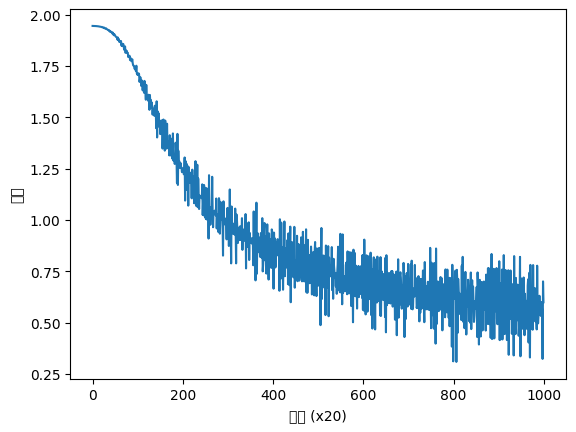

In [36]:
from common.trainer import Trainer
from common.optimizer import Adam


## 여기도 실험 여지
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [37]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id]) ## 당연히 교재와 다른 결과

you [ 1.3153528 -1.2968702  1.08624    0.9926823  1.1026455]
say [ 0.14624652  1.1365981  -1.138328   -1.1549628  -1.1416163 ]
goodbye [ 0.65304166 -0.47664928  0.8015656   0.9584683   0.78491205]
and [ 1.9874476  0.8746683 -0.8633898 -0.5999941 -0.880847 ]
i [ 0.6609997  -0.47548223  0.7922549   0.97527224  0.78832275]
hello [ 1.3236268 -1.2907934  1.0975481  0.9659215  1.0831721]
. [-1.6547905  1.1302147 -1.0860863 -1.230025  -1.1312742]
